# Demand Forecasting using LSTM

The objective is to predict the electricity consuumption of a household with a one-minute sampling rate based on the past 4 years of consumption

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from time import time

# Suppress Scientific notations and display float up to 2 decimals
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv('household_power_consumption.txt', delimiter=';')
df.head()

C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00


In [3]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


## Prepare the data

For this problem we will do a Univariate time series modeling using only the Global_active_power as the variable.
So let us keep only the columns that we need, and also convert the Global_active_power to numeric

1) Create a Date-Time column
<br>2) Keep only the columns we need
<br>3) Address missing values
<br>4) Convert all the data to float
<br>5) Create columns for Year, Quarter, Month, Day, Weekday to observe the trends

In [4]:
# Create a new column for Date-time
df['Datetime'] = pd.to_datetime(df.Date + ' ' + df.Time)

In [5]:
# Keep only the columns we need
df = df.loc[:,['Datetime','Global_active_power']]
df.head()

,Datetime,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666


In [7]:
df.tail()

,Datetime,Global_active_power
2075254,2010-11-26 20:58:00,0.95
2075255,2010-11-26 20:59:00,0.94
2075256,2010-11-26 21:00:00,0.94
2075257,2010-11-26 21:01:00,0.93
2075258,2010-11-26 21:02:00,0.93


In [8]:
# The missing values are denoted by "?". Let us check how many missing values are there in each column
df.apply(lambda x : sum(x=="?"))

Datetime                   0
Global_active_power    25979
dtype: int64

In [6]:
# Fill all the missing values with the data from the previous row (previous minute)
df.replace('?', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.apply(lambda x : sum(x=='?'))

Datetime               0
Global_active_power    0
dtype: int64

In [7]:
# Convert to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'])

In [8]:
# Ensure the data is sorted
df.sort_values('Datetime', inplace=True, ascending=True)

In [9]:
# Set the Datetime column as the index
df.set_index('Datetime', inplace=True)

df.head()

,Global_active_power
Datetime,
2006-12-16 17:24:00,4.22
2006-12-16 17:25:00,5.36
2006-12-16 17:26:00,5.37
2006-12-16 17:27:00,5.39
2006-12-16 17:28:00,3.67


In [10]:
# Save the processed file for future use
df.to_csv('household_power_consumption_final.csv')

## Plotting the time series

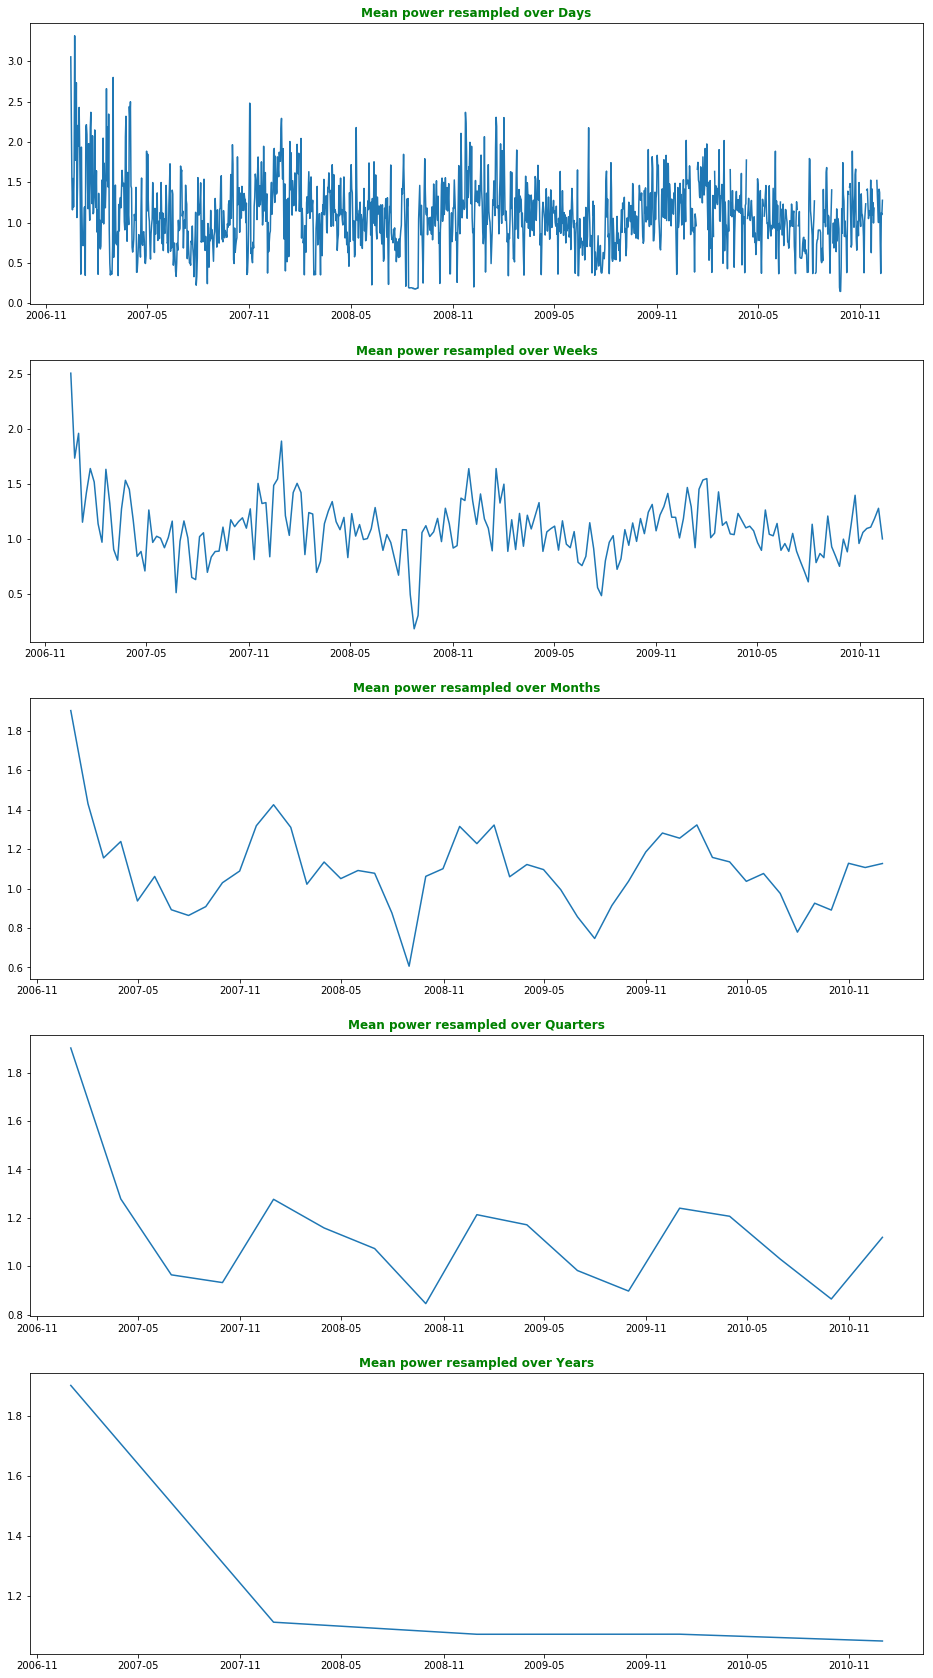

In [11]:
# Plot the average Daily consumption on different time scales
fig, ax = plt.subplots(5, figsize=(16,30))

# Daily
ax[0].plot(df['Global_active_power'].resample('D').mean())
ax[0].set_title('Mean power resampled over Days',fontweight="bold", color='g')

# Weekly
ax[1].plot(df['Global_active_power'].resample('W').mean())
ax[1].set_title('Mean power resampled over Weeks',fontweight="bold", color='g')

# Monthly
ax[2].plot(df['Global_active_power'].resample('M').mean())
ax[2].set_title('Mean power resampled over Months',fontweight="bold", color='g')

# Quarterly
ax[3].plot(df['Global_active_power'].resample('Q').mean())
ax[3].set_title('Mean power resampled over Quarters',fontweight="bold", color='g')

# Yearly
ax[4].plot(df['Global_active_power'].resample('Y').mean())
ax[4].set_title('Mean power resampled over Years',fontweight="bold", color='g')

plt.show()

## Check if the series is Stationary

We will use the Dickey-Fuller test to check this

H0: The time-series has a unit root, i.e. it is NOT stationary
<br>H1: The time series is stationary

In [12]:
# Aggregate the data at a day level
daily_data = df.resample('D').mean()

# Check if there are any NaNs in the daily data
np.sum(daily_data.isna())

# Replace the NaNs by the previous day's value
daily_data.fillna(method='ffill', inplace=True)

daily_data.head()

,Global_active_power
Datetime,
2006-12-16,3.05
2006-12-17,2.35
2006-12-18,1.53
2006-12-19,1.16
2006-12-20,1.55


In [13]:
# Define a function to check the Stationarity

from statsmodels.tsa.stattools import adfuller

def Stationarity_Check(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags used','#Observations'])
    print("\nResults of the Augmented Dickey Fuller Test : \n")
    print (dfoutput)

In [14]:
# Perform the DF test to verify the stationarity

Stationarity_Check(daily_data.Global_active_power.values)


Results of the Augmented Dickey Fuller Test : 

Test Statistic     -8.29
p-value             0.00
#Lags used          9.00
#Observations    1447.00
dtype: float64


From the p-value we can reject the Null hypothesis and conclude that the data is Stationary

## Time series modeling using LSTM

### Prepare the data for modeling

In [15]:
data = df['Global_active_power'].values

In [16]:
data

array([4.216, 5.36 , 5.374, ..., 0.688, 0.688, 0.688])

In [17]:
data = data.reshape((-1,1))

In [18]:
data

array([[4.216],
       [5.36 ],
       [5.374],
       ...,
       [0.688],
       [0.688],
       [0.688]])

In [19]:
data.shape

(2075259, 1)

In [20]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [21]:
int(len(data) * 0.8)

1660207

In [22]:
# Split into training/test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size,], data[train_size:,]

In [23]:
train

array([[0.37479631],
       [0.47836321],
       [0.47963064],
       ...,
       [0.16621401],
       [0.16603295],
       [0.16548977]])

In [24]:
test

array([[0.16657614],
       [0.16693826],
       [0.16548977],
       ...,
       [0.05540467],
       [0.05540467],
       [0.05540467]])

In [25]:
# Prepare the data in a format required for LSTM (samples, timesteps, features)

def Create_Dataset(df, lookback=1):
    X, Y = [], []
    for i in range(len(df) - lookback - 1):
        X.append(df[i:(i+lookback), 0])
        Y.append(df[i + lookback,0])
    return np.array(X), np.array(Y)

In [26]:
lookback = 30
X_train, Y_train = Create_Dataset(train, lookback)
X_test, Y_test   = Create_Dataset(test, lookback)

In [27]:
X_train

array([[0.37479631, 0.47836321, 0.47963064, ..., 0.28535216, 0.28806808,
        0.28082564],
       [0.47836321, 0.47963064, 0.48089806, ..., 0.28806808, 0.28082564,
        0.23936267],
       [0.47963064, 0.48089806, 0.32500453, ..., 0.28082564, 0.23936267,
        0.33333333],
       ...,
       [0.17762086, 0.19391635, 0.19681333, ..., 0.15734202, 0.1676625 ,
        0.16784356],
       [0.19391635, 0.19681333, 0.18721709, ..., 0.1676625 , 0.16784356,
        0.16711932],
       [0.19681333, 0.18721709, 0.1709216 , ..., 0.16784356, 0.16711932,
        0.16621401]])

In [28]:
Y_train

array([0.23936267, 0.33333333, 0.38620315, ..., 0.16711932, 0.16621401,
       0.16603295])

In [29]:
X_train.shape

(1660176, 30)

In [30]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [31]:
X_train

array([[[0.37479631, 0.47836321, 0.47963064, ..., 0.28535216,
         0.28806808, 0.28082564]],

       [[0.47836321, 0.47963064, 0.48089806, ..., 0.28806808,
         0.28082564, 0.23936267]],

       [[0.47963064, 0.48089806, 0.32500453, ..., 0.28082564,
         0.23936267, 0.33333333]],

       ...,

       [[0.17762086, 0.19391635, 0.19681333, ..., 0.15734202,
         0.1676625 , 0.16784356]],

       [[0.19391635, 0.19681333, 0.18721709, ..., 0.1676625 ,
         0.16784356, 0.16711932]],

       [[0.19681333, 0.18721709, 0.1709216 , ..., 0.16784356,
         0.16711932, 0.16621401]]])

In [33]:
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [28]:
X_train.shape

(1660176, 1, 30)

In [29]:
X_test.shape

(415021, 1, 30)

In [30]:
# Print the data
print("X_train : \n")
print(X_train[:2])

print("\n\nY_train : \n")
print(Y_train[:2])


X_train : 

[[[0.37479631 0.47836321 0.47963064 0.48089806 0.32500453 0.31178707
   0.32826362 0.32808256 0.32518559 0.3246424  0.39579938 0.48307079
   0.46605106 0.4700344  0.36013036 0.29947492 0.28915445 0.30363933
   0.28879232 0.33061742 0.5267065  0.69074778 0.62918704 0.46152453
   0.39815318 0.28716277 0.28607641 0.28535216 0.28806808 0.28082564]]

 [[0.47836321 0.47963064 0.48089806 0.32500453 0.31178707 0.32826362
   0.32808256 0.32518559 0.3246424  0.39579938 0.48307079 0.46605106
   0.4700344  0.36013036 0.29947492 0.28915445 0.30363933 0.28879232
   0.33061742 0.5267065  0.69074778 0.62918704 0.46152453 0.39815318
   0.28716277 0.28607641 0.28535216 0.28806808 0.28082564 0.23936267]]]


Y_train : 

[0.23936267 0.33333333]


In [34]:
# Check the shapes of the data for modeling
print("X_train : ", X_train.shape)
print("Y_train : ", Y_train.shape)
print("\nX_test : ", X_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (1660176, 1, 30)
Y_train :  (1660176,)

X_test :  (415021, 1, 30)
Y_test :  (415021,)


### Build the LSTM model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping # Optional

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [36]:
model = Sequential()

In [39]:
X_train.shape[1]

1

In [40]:
X_train.shape[2]

30

In [44]:
model.add(LSTM(100, input_shape=( X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [47]:
history = model.fit(X_train, Y_train, 
                    epochs=2, 
                    batch_size=50,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1,
                    shuffle=False)

Train on 1660176 samples, validate on 415021 samples
Epoch 1/2
1660176/1660176 [==============================] - 213s 128us/step - loss: 7.4583e-04 - val_loss: 4.3407e-04
Epoch 2/2
1660176/1660176 [==============================] - 202s 122us/step - loss: 6.6893e-04 - val_loss: 4.3475e-04


### Make the predictions and convert back to the original scale

In [51]:
# Make the predictions
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test)

# Invert the predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict  = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


### Check the RMSE scores

In [83]:
from sklearn.metrics import mean_squared_error

print ("Train MAE : ", mean_squared_error(Y_train[0], train_predict[:,0]))
print ("Train RMSE : ", np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))

print ("\nTest MAE : ", mean_squared_error(Y_test[0], test_predict[:,0]))
print ("Test RMSE : ", np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Mape_train =np.mean(np.abs(Y_train[0] - train_predict[:,0])/Y_train[0])
Mape_test =np.mean(np.abs(Y_test[0] - test_predict[:,0])/Y_test[0])

print ("\nTrain MAPE : ", Mape_train)
print ("Test MAPE : ", Mape_test)


Train MAE :  0.07699051922686272
Train RMSE :  0.27747165481696096

Test MAE :  0.05304537218959897
Test RMSE :  0.23031580968226859

Train MAPE :  0.2551950654980429
Test MAPE :  0.2268989569095004


### Plot the model losses

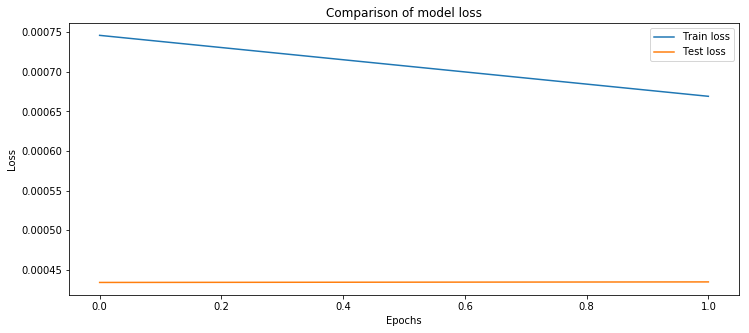

In [53]:
plt.figure(figsize=(12,5))
plt.title('Comparison of model loss')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### Plot the predicted vs actual values

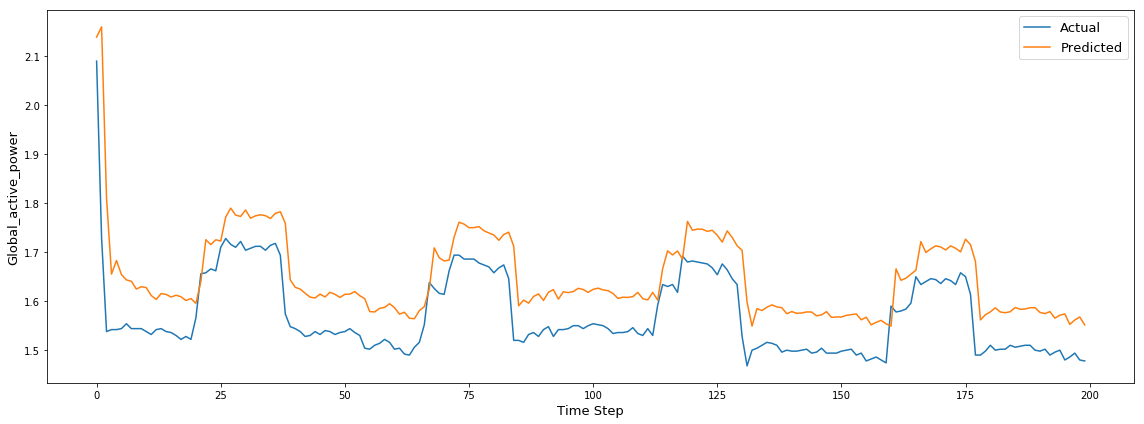

In [54]:
actual = Y_test[0][:200]
predicted = test_predict[:,0][:200]

plt.figure(figsize=(16,6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.ylabel('Global_active_power', size=13)
plt.xlabel('Time Step', size=13)
plt.tight_layout()
plt.legend(fontsize=13)
plt.show()

In [82]:
##Forecasting for future time periods
y = []
for i in range(0,30):
    X1 = test[len(test)-30+i:,0]
    X1 = np.append(X1, y)
    X1 = X1.reshape(1,1,30)
    y1 = model.predict(X1)
    y.append(y1)
    print(y1)

[[0.06362007]]
[[0.07230723]]
[[0.08059312]]
[[0.0885074]]
[[0.09615821]]
[[0.10323027]]
[[0.10992005]]
[[0.11629398]]
[[0.1223743]]
[[0.12809676]]
[[0.13358775]]
[[0.13879584]]
[[0.14358287]]
[[0.14795181]]
[[0.15201391]]
[[0.15581498]]
[[0.15943474]]
[[0.16298725]]
[[0.1665397]]
[[0.17013907]]
[[0.17374983]]
[[0.17738965]]
[[0.1811071]]
[[0.18490377]]
[[0.18877289]]
[[0.19267651]]
[[0.19657113]]
[[0.20043138]]
[[0.20422104]]
[[0.20789176]]
